### Description (ENG)
Maintaining and stimulating user activity is an important task for a product like ours. To do this, our team of marketers decided to organize a flashmob in the news feed: participants must make a post where they tell some interesting fact about themselves and publish it with a hashtag. The three posts with the most likes receive prizes.

The flashmob took place from 2023-10-12 to 2023-10-18. Our task as an analyst is to evaluate the effectiveness of this event.

**Task:**

1) Guess which metrics should have changed during the flashmob and how. Why? Offer at least 5 metrics.
2) Check if these metrics actually changed using CausalImpact. If a change actually occurred, describe exactly how the metric changed and by how much.
3) Did the flashmob have any long-term effects? Draw conclusions.

### Description (RUS)
Поддерживать и стимулировать пользовательскую активность – важная задача для продукта, подобного нашему. Для этого наша команда маркетологов решила организовать флэшмоб в ленте новостей: участники должны сделать пост, где они рассказывают какой-то интересный факт о себе, и опубликовать его с хэштегом. Три поста, собравших наибольшее число лайков, получают призы.

Флэшмоб проходил с 2023-10-12 по 2023-10-18. Наша задача как аналитика – оценить эффективность этого мероприятия.

**Задание:**

1) Предположите, какие метрики должны были измениться во время флэшмоба и как. Почему? Предложите хотя бы 5 метрик.
2) Проверьте, реально ли эти метрики изменились, используя CausalImpact. Если изменение действительно произошло - опишите, как именно изменилась метрика и насколько.
3) Имел ли флэшмоб какие-то долгосрочные эффекты? Сделайте выводы.

In [2]:
import pandas as pd
import pandahouse
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
from causalimpact import CausalImpact

2023-11-03 10:55:51.855069: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-03 10:55:52.303549: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-03 10:55:52.305158: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-03 10:55:54.684326: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


**Selecting metrics:**

Metrics were selected based on the following logic:

- Flash mob stimulates user activity $\Longrightarrow$ we expect an increase in **DAU**, **views** and **number of new users** who want to take part in the competition or simply help a friend with a like.

- To receive a prize, you must collect the largest number of likes $\Longrightarrow$ we expect a significant increase in **total number of likes**, as well as **number of likes per user** and, possibly, a change in **CTR** and **number of views per user**.

Thus, we're gonna consider the following metrics: **DAU**, **views**, **number of new users**, **likes**, **likes per user**, **CTR** and **views per user**.

First, let's extract data from Clickhouse. 

In [4]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

q = """
select * from

(select toDate(time) as date, count(distinct user_id) as DAU, 
countIf(action='view') as views, countIf(action='like') as likes, countIf(action='like')/countIf(action='view') as CTR,
countIf(action='like') / count(distinct user_id) as avg_likes, 
countIf(action='view') / count(distinct user_id) as avg_views
from simulator_20231020.feed_actions
group by date) t1

join

(select start_date as date, count(user_id) as new_users
from
(select user_id, min(toDate(time)) as start_date
from simulator_20231020.feed_actions
group by user_id) 
group by date) t2

using(date)
"""
df = pandahouse.read_clickhouse(q, connection=connection)

In [5]:
df.head()

,date,DAU,views,likes,CTR,avg_likes,avg_views,new_users
0,2023-09-01,878,7603,1560,0.205182,1.776765,8.659453,878
1,2023-09-02,2238,62770,12816,0.204174,5.726542,28.047364,1819
2,2023-09-03,3105,105526,20958,0.198605,6.749758,33.985829,1849
3,2023-09-04,3721,118996,23800,0.200007,6.396130,31.979575,1652
4,2023-09-05,4617,174454,34504,0.197783,7.473251,37.785142,1809


In [21]:
df.date[len(df)-1]

Timestamp('2023-11-03 00:00:00')

In [6]:
# flashmob dates
df_flashmob = df[(df.date == '2023-10-12') | ((df.date == '2023-10-18'))].copy()

Let's take a visual look at how our metrics changed before, during and after the flash mob:

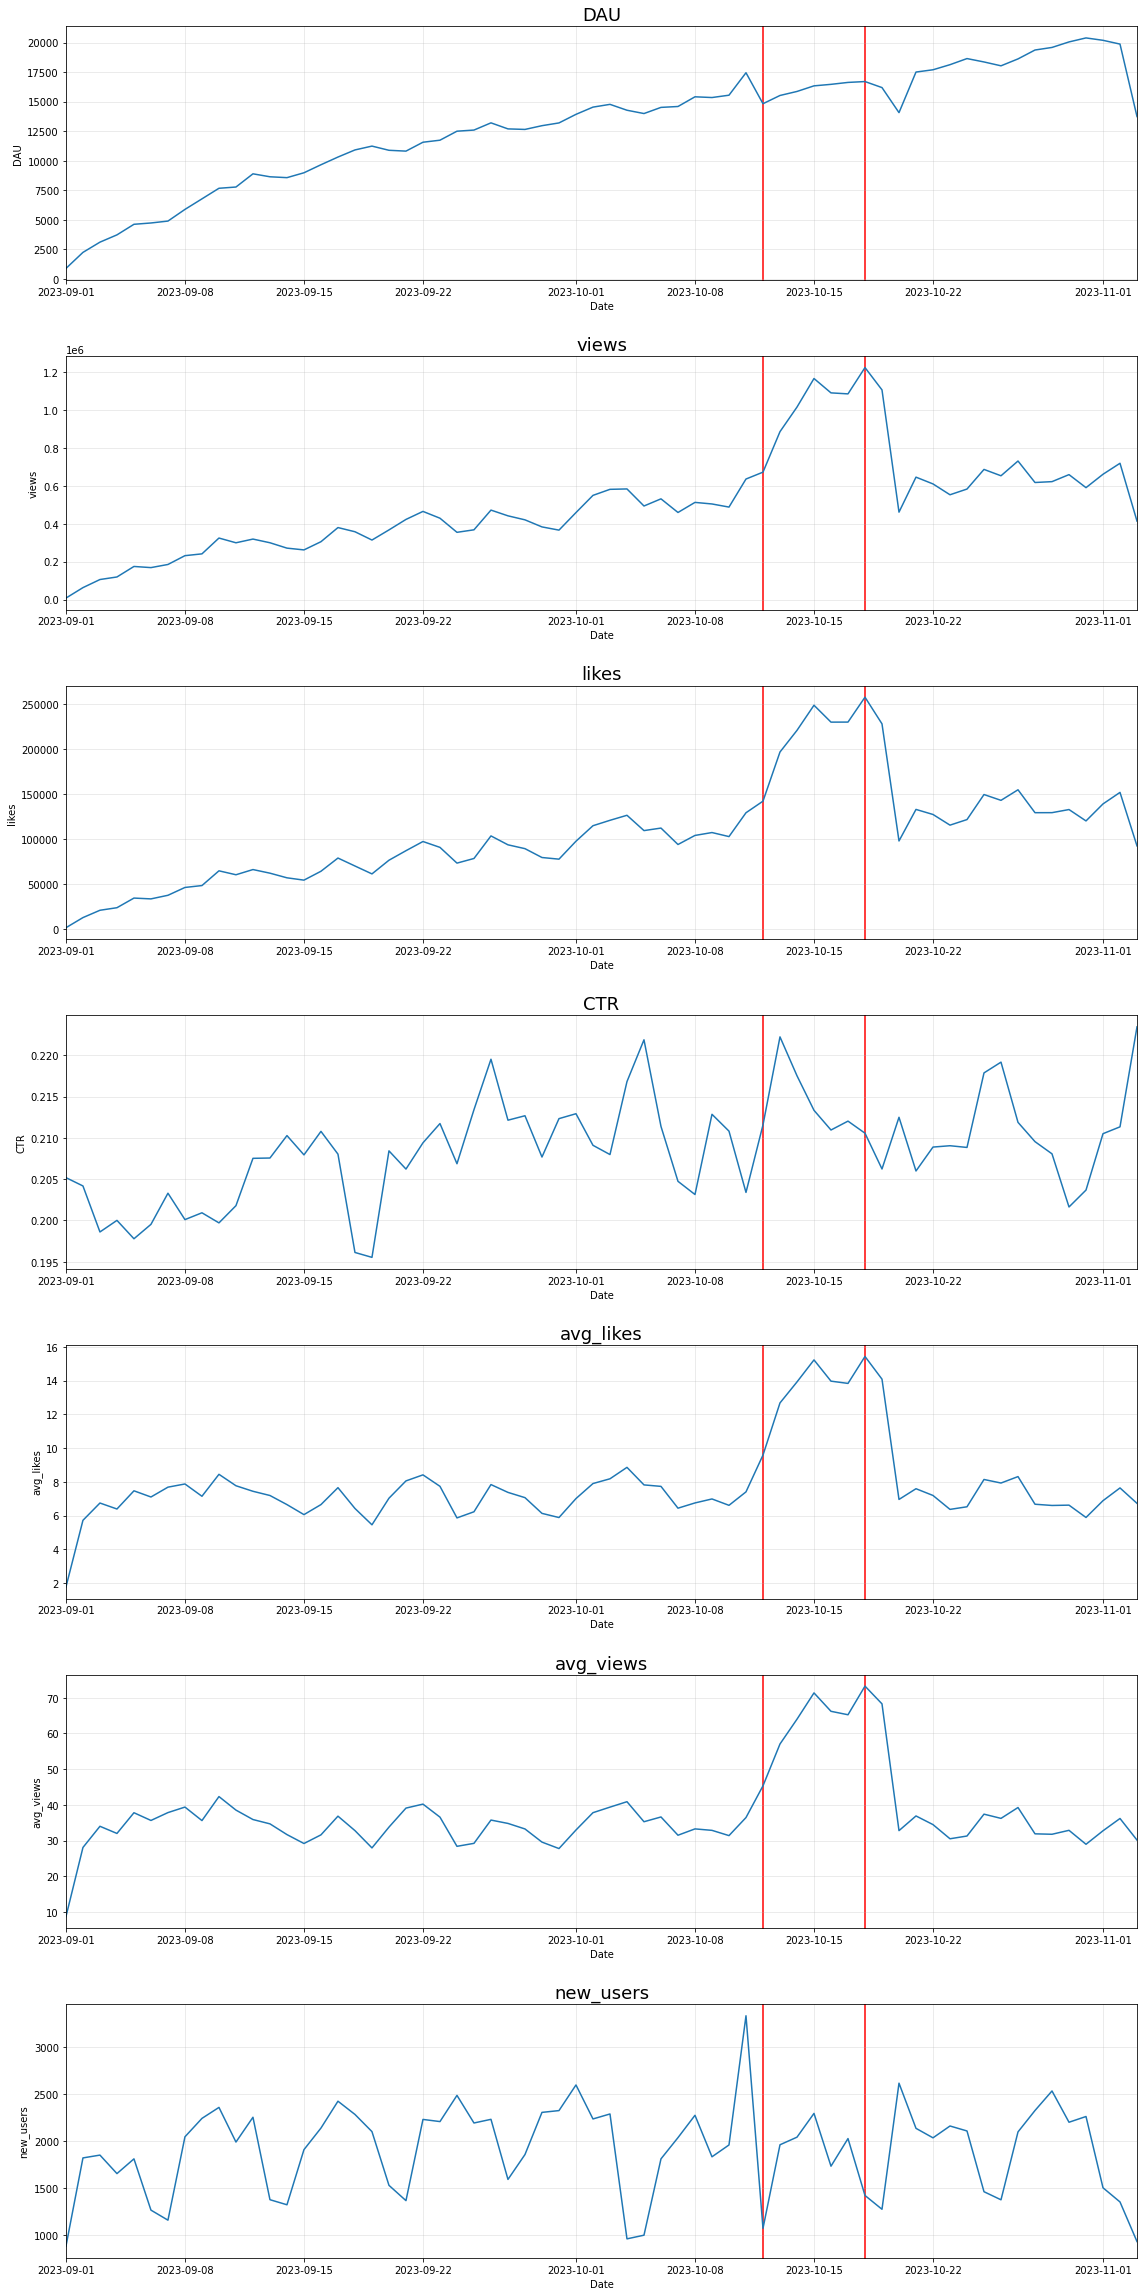

In [32]:
metrics = ['DAU', 'views', 'likes', 'CTR', 'avg_likes', 'avg_views', 'new_users']
figs, axs = plt.subplots(len(metrics),1, figsize=(16,32))

for i in range(len(metrics)):
    axs[i].plot(df.date, df[metrics[i]])
    axs[i].set(xlabel='Date', ylabel=metrics[i], title=metrics[i])
    axs[i].grid(axis='both', alpha=.3)
    axs[i].set_xlim([df.date[0], df.date[len(df)-1]])
    axs[i].set_title(metrics[i], fontsize=18)
    
    # Flashmob period
    axs[i].scatter(df_flashmob.date, df_flashmob[metrics[i]], c='red', s=1e6, alpha=1, marker="|")
    
figs.tight_layout()
plt.subplots_adjust(wspace=.3, hspace=.3)

**Conclusion**: from the analysis of the figures it is clear that during the flash mob there was a noticeable jump in likes and views. However, after the end of the flashmob, these figures began to decline sharply. Thus, visually, the flashmob did not affect user activity in the long term (based on the selected metrics).

In [32]:
df.set_index('date', inplace=True)

### CausalImpact

### DAU

In [33]:
impact = CausalImpact(df.DAU, 
                      pre_period=['2023-09-03',  '2023-10-11'], 
                      post_period=['2023-10-12', '2023-10-18']) 

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


2023-11-02 21:06:36.438417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-11-02 21:06:36.438944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-11-02 21:06:36.458211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-11-02 21:06:36.458424: I tens

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`


2023-11-02 21:06:37.906096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-11-02 21:06:37.945058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_1_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-11-02 21:06:38.000395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node monte_carlo_variational_loss/expectation/powerInv

Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


2023-11-02 21:07:02.698788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2023-11-02 21:07:02.813705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

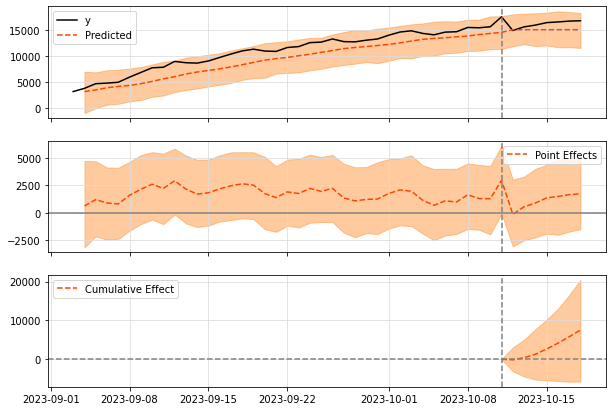

In [34]:
impact.plot()

In [35]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    16052.71           112369.0
Prediction (s.d.)         14978.92 (970.63)  104852.44 (6794.42)
95% CI                    [13001.39, 16806.2][91009.76, 117643.39]

Absolute effect (s.d.)    1073.79 (970.63)   7516.56 (6794.42)
95% CI                    [-753.49, 3051.32] [-5274.39, 21359.24]

Relative effect (s.d.)    7.17% (6.48%)      7.17% (6.48%)
95% CI                    [-5.03%, 20.37%]   [-5.03%, 20.37%]

Posterior tail-area probability p: 0.12
Posterior prob. of a causal effect: 88.21%

For more details run the command: print(impact.summary('report'))


In [36]:
print(impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 16052.71. In the absence of an
intervention, we would have expected an average response of 14978.92.
The 95% interval of this counterfactual prediction is [13001.39, 16806.2].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 1073.79 with a 95% interval of
[-753.49, 3051.32]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 112369.0.
Had the intervention not taken place, we would have expected
a sum of 104852.44. The 95% interval of this prediction is [91009.76, 117643.39].


The above results are given in terms of absolute numbers. In relative
terms, the response varia

**Thus**, there is a positive change in the DAU metric during the flash mob (+7.17%), but it is statistically insignificant. See above for more details.

### Views

In [37]:
impact = CausalImpact(df.views, 
                      pre_period=['2023-09-03',  '2023-10-11'], 
                      post_period=['2023-10-12', '2023-10-18']) 

2023-11-02 21:20:18.488049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-11-02 21:20:18.530373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-11-02 21:20:19.448399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-11-02 21:

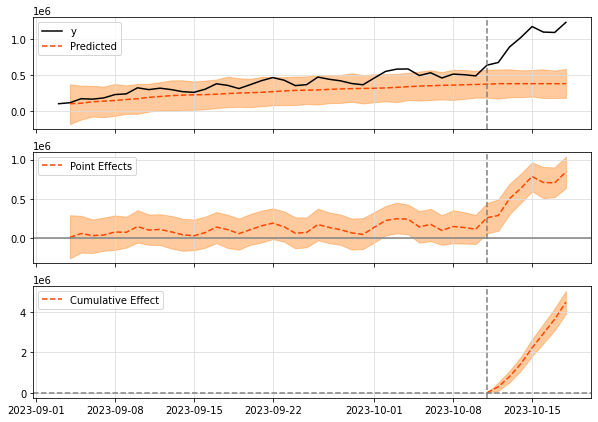

In [38]:
impact.plot()

In [39]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1019947.31         7139631.0
Prediction (s.d.)         381226.28 (39259.01)2668584.0 (274813.13)
95% CI                    [304188.02, 458080.56][2129316.06, 3206563.97]

Absolute effect (s.d.)    638721.0 (39259.01)4471047.0 (274813.13)
95% CI                    [561866.75, 715759.3][3933067.03, 5010314.94]

Relative effect (s.d.)    167.54% (10.3%)    167.54% (10.3%)
95% CI                    [147.38%, 187.75%] [147.38%, 187.75%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [40]:
print(impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 1019947.31. By contrast, in the absence of an
intervention, we would have expected an average response of 381226.28.
The 95% interval of this counterfactual prediction is [304188.02, 458080.56].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 638721.0 with a 95% interval of
[561866.75, 715759.3]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 7139631.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 2668584.0. The 95% interval of this prediction is [2129316.06, 3206563.97].


The above results are given in terms of absolute number

**Thus**, a statistically significant increase in the total number of views during the flash mob was recorded (+167.54). See above for more details.

### Likes

In [41]:
impact = CausalImpact(df.likes, 
                      pre_period=['2023-09-03',  '2023-10-11'], 
                      post_period=['2023-10-12', '2023-10-18']) 

2023-11-02 21:23:46.932500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-11-02 21:23:46.969637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-11-02 21:23:47.836513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-11-02 21:

2023-11-02 21:24:12.856356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2023-11-02 21:24:13.011027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

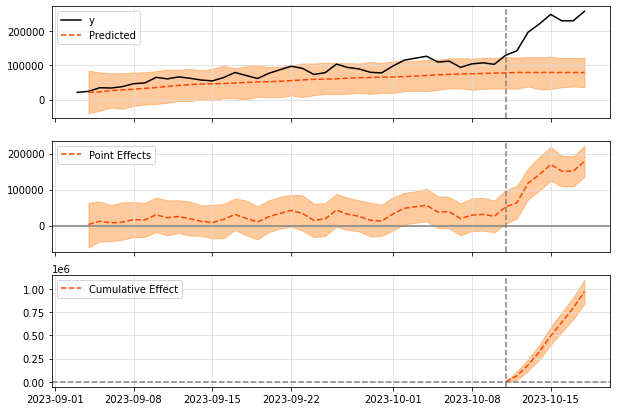

In [42]:
impact.plot()

In [43]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    218090.14          1526631.0
Prediction (s.d.)         79228.18 (9059.28) 554597.25 (63414.99)
95% CI                    [61779.04, 97290.79][432453.27, 681035.53]

Absolute effect (s.d.)    138861.97 (9059.28)972033.75 (63414.99)
95% CI                    [120799.35, 156311.1][845595.47, 1094177.73]

Relative effect (s.d.)    175.27% (11.43%)   175.27% (11.43%)
95% CI                    [152.47%, 197.29%] [152.47%, 197.29%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [44]:
print(impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 218090.14. By contrast, in the absence of an
intervention, we would have expected an average response of 79228.18.
The 95% interval of this counterfactual prediction is [61779.04, 97290.79].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 138861.97 with a 95% interval of
[120799.35, 156311.1]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 1526631.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 554597.25. The 95% interval of this prediction is [432453.27, 681035.53].


The above results are given in terms of absolute numbers. In

**Thus**, a statistically significant increase in the total number of likes during the flash mob was recorded (+175.27%). See above for more details.

### CTR

In [46]:
impact = CausalImpact(df.CTR, 
                      pre_period=['2023-09-03',  '2023-10-11'], 
                      post_period=['2023-10-12', '2023-10-18']) 

2023-11-02 21:56:57.134767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-11-02 21:56:57.173956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-11-02 21:56:57.954658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-11-02 21:

2023-11-02 21:57:20.164272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2023-11-02 21:57:20.285862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

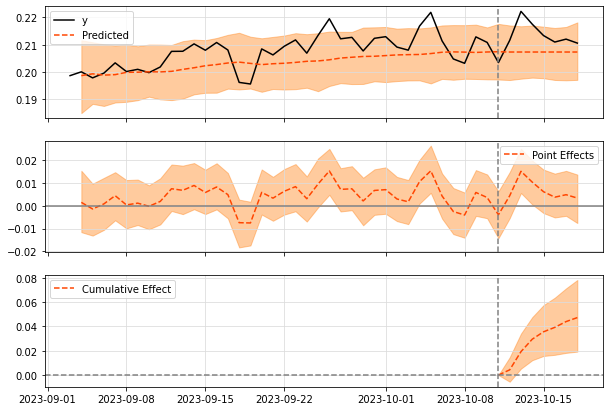

In [47]:
impact.plot()

In [48]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.21               1.5
Prediction (s.d.)         0.21 (0.0)         1.45 (0.01)
95% CI                    [0.2, 0.21]        [1.42, 1.48]

Absolute effect (s.d.)    0.01 (0.0)         0.05 (0.01)
95% CI                    [0.0, 0.01]        [0.02, 0.08]

Relative effect (s.d.)    3.25% (1.03%)      3.25% (1.03%)
95% CI                    [1.15%, 5.18%]     [1.15%, 5.18%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 99.8%

For more details run the command: print(impact.summary('report'))


In [49]:
print(impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 0.21. By contrast, in the absence of an
intervention, we would have expected an average response of 0.21.
The 95% interval of this counterfactual prediction is [0.2, 0.21].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 0.01 with a 95% interval of
[0.0, 0.01]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 1.5.
By contrast, had the intervention not taken place, we would have expected
a sum of 1.45. The 95% interval of this prediction is [1.42, 1.48].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an incre

**Thus**, there is a slight positive change in the CTR metric during the flash mob (+3.25%), and it is statistically significant. See above for more details.

### Average likes per a user

In [50]:
impact = CausalImpact(df.avg_likes, 
                      pre_period=['2023-09-03',  '2023-10-11'], 
                      post_period=['2023-10-12', '2023-10-18']) 

2023-11-02 22:09:36.880331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-11-02 22:09:36.914802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-11-02 22:09:37.663260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-11-02 22:

2023-11-02 22:10:00.896859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2023-11-02 22:10:01.031429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

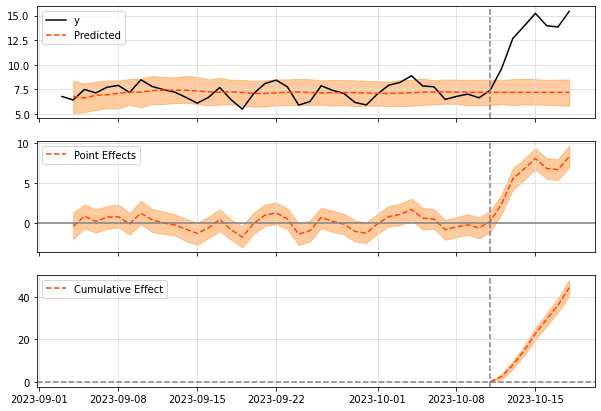

In [51]:
impact.plot()

In [52]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    13.52              94.65
Prediction (s.d.)         7.17 (0.26)        50.18 (1.8)
95% CI                    [6.66, 7.66]       [46.61, 53.65]

Absolute effect (s.d.)    6.35 (0.26)        44.47 (1.8)
95% CI                    [5.86, 6.86]       [41.0, 48.04]

Relative effect (s.d.)    88.62% (3.58%)     88.62% (3.58%)
95% CI                    [81.71%, 95.73%]   [81.71%, 95.73%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [53]:
print(impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 13.52. By contrast, in the absence of an
intervention, we would have expected an average response of 7.17.
The 95% interval of this counterfactual prediction is [6.66, 7.66].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 6.35 with a 95% interval of
[5.86, 6.86]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 94.65.
By contrast, had the intervention not taken place, we would have expected
a sum of 50.18. The 95% interval of this prediction is [46.61, 53.65].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed 

**Thus**, a statistically significant increase in the number of likes per user during the flash mob was recorded (+88.62%). See above for more details.

### Average views per a user

In [54]:
impact = CausalImpact(df.avg_views, 
                      pre_period=['2023-09-03',  '2023-10-11'], 
                      post_period=['2023-10-12', '2023-10-18']) 

2023-11-02 22:13:20.122032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-11-02 22:13:20.157267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-11-02 22:13:20.935759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-11-02 22:

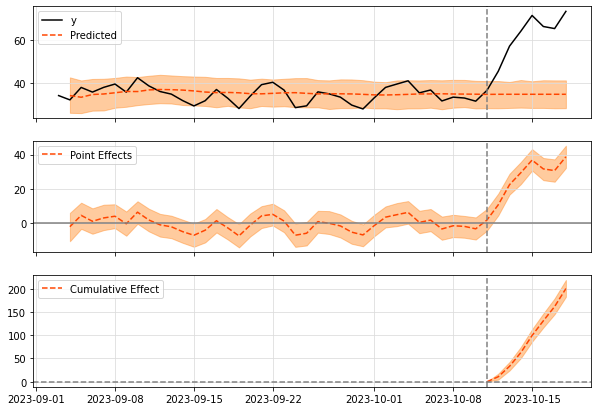

In [55]:
impact.plot()

In [56]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    63.21              442.5
Prediction (s.d.)         34.59 (1.38)       242.15 (9.69)
95% CI                    [31.81, 37.24]     [222.65, 260.65]

Absolute effect (s.d.)    28.62 (1.38)       200.35 (9.69)
95% CI                    [25.98, 31.41]     [181.85, 219.85]

Relative effect (s.d.)    82.74% (4.0%)      82.74% (4.0%)
95% CI                    [75.1%, 90.79%]    [75.1%, 90.79%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [57]:
print(impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 63.21. By contrast, in the absence of an
intervention, we would have expected an average response of 34.59.
The 95% interval of this counterfactual prediction is [31.81, 37.24].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 28.62 with a 95% interval of
[25.98, 31.41]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 442.5.
By contrast, had the intervention not taken place, we would have expected
a sum of 242.15. The 95% interval of this prediction is [222.65, 260.65].


The above results are given in terms of absolute numbers. In relative
terms, the response variabl

**Thus**, a statistically significant increase in the number of views per user during the flash mob was recorded (+82.74%). See above for more details.

### New users

In [58]:
impact = CausalImpact(df.new_users, 
                      pre_period=['2023-09-03',  '2023-10-11'], 
                      post_period=['2023-10-12', '2023-10-18']) 

2023-11-02 22:15:34.880563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-11-02 22:15:34.919828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-11-02 22:15:35.729008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-11-02 22:

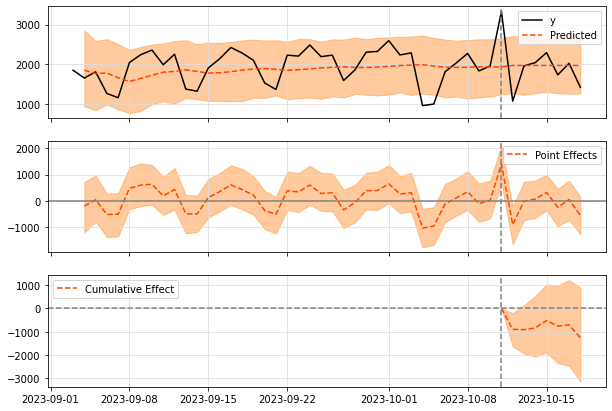

In [59]:
impact.plot()

In [60]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1790.86            12536.0
Prediction (s.d.)         1970.93 (145.11)   13796.51 (1015.74)
95% CI                    [1694.33, 2263.14] [11860.34, 15841.99]

Absolute effect (s.d.)    -180.07 (145.11)   -1260.51 (1015.74)
95% CI                    [-472.28, 96.52]   [-3305.99, 675.66]

Relative effect (s.d.)    -9.14% (7.36%)     -9.14% (7.36%)
95% CI                    [-23.96%, 4.9%]    [-23.96%, 4.9%]

Posterior tail-area probability p: 0.11
Posterior prob. of a causal effect: 88.81%

For more details run the command: print(impact.summary('report'))


In [61]:
print(impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 1790.86. In the absence of an
intervention, we would have expected an average response of 1970.93.
The 95% interval of this counterfactual prediction is [1694.33, 2263.14].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -180.07 with a 95% interval of
[-472.28, 96.52]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 12536.0.
Had the intervention not taken place, we would have expected
a sum of 13796.51. The 95% interval of this prediction is [11860.34, 15841.99].


The above results are given in terms of absolute numbers. In relative
terms, the response variable show

### Results

**Thus**, as a result of the flashmob, a statistically insignificant drop in the number of new users (-9.14%) was recorded. See above for more details. At the same time from the graph you can see that the day before the start of the flash mob there was a jump in the number of new registered users, which quickly faded away. It can be assumed that the vast majority of those who wanted to register in the application for the sake of the flash mob (to take part and/or support a friend) did so the day before it started.

**General conclusion:** On the one hand the flashmob had a positive, statistically significant impact on the total number of likes and views of users. At the same time, the increase in activity in the application was limited only to the flashmob period and had no visual impact on these metrics in the long term. Also, during the flashmob, not only likes and views increased, but also related metrics - the number of likes and views per user. The changes are statistically significant. In addition, there was a small but statistically significant increase in CTR.